# DPX TP-Calibration
Same as THL-Calibration but now only using the test pulses

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import os
import time
import cPickle
import hickle
%matplotlib inline
%config InlineBackend.figure_format = 'png'

# Support functions
import dpx_func_python as su
import plotToTtoTHL as pttt
import plotTemperatureToT as pTT
import ToTtoEnergy as tte
import THLConversion as thlc

# Reload
reload(su), reload(pttt), reload(tte), reload(thlc), reload(pTT)

(<module 'dpx_func_python' from 'dpx_func_python.pyc'>,
 <module 'plotToTtoTHL' from 'plotToTtoTHL.pyc'>,
 <module 'ToTtoEnergy' from 'ToTtoEnergy.pyc'>,
 <module 'THLConversion' from 'THLConversion.pyc'>,
 <module 'plotTemperatureToT' from 'plotTemperatureToT.pyc'>)

In [2]:
def linear(x, m, t):
    return m*x + t

def energyToToTSimple(x, a, b, c, t):
    res = np.where(x >= b, a*(x - b) - c * (np.pi / 2 + t / (x - b)), 0)
    res[res < 0] = 0
    return res

def ToTtoEnergySimple(x, a, b, c, t, h=1, k=0):
    return h * (b + 1./(4 * a) * (2*x + np.pi*c + np.sqrt(16 * a * c * t + (2 * x + np.pi * c)**2))) + k

def fitFunc(x, a, b, c, t, d):
    return -a * np.sin((t + (np.log((x - b) * d)))*(x - b) / c) / (x - b) 

def fitFunc2(x, a, b, c, t):
    return a * (x - b)*np.cos((x - b) / t)*np.exp(-(x - b) / c) 

def superFit(x, a1, b1, c1, t1, a2, b2, c2, t2):
    y1, y2 = energyToToTSimple(x, a1, b1, c1, t1), fitFunc2(x, a2, b2, c2, t2)
    # y2[y1 <= 0] = 0
    y = y1 + y2
    y[y < 0] = 0
    return y

# Get color
def getColor(c, N, idx):
    import matplotlib as mpl
    cmap = mpl.cm.get_cmap(c)
    norm = mpl.colors.Normalize(vmin=0.0, vmax=N - 1)
    return cmap(norm(idx))

### Directories

In [3]:
CALIB_DIRECTORY = '../../../energy_calibration/paramsRes/'
CALIB_FN = 'detector%dDataTHL20.p'
TP_DIRECTORY = '../../dpx_data/TPtoToT_Dennis1/'
TP_FN = 'TPtoToT_detector%d.hck'
PLOT_DIR = 'publish/'

In [4]:
p0 = (0.6948303391178534, 3.194289992217462, -22.303556749429706, -2.2245295778849186)

d = cPickle.load(open(CALIB_DIRECTORY + CALIB_FN % 1, 'rb'))
data = hickle.load(TP_DIRECTORY + TP_FN % 1)

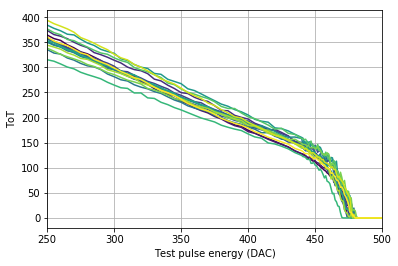

In [5]:
for i in range(16):
    color = getColor('viridis', 16, i)
    plt.plot(data[0]['volt'], np.asarray(data[0]['ToT']).T[i], color=color)
plt.grid()
plt.xlim(250, 500)
plt.xlabel('Test pulse energy (DAC)')
plt.ylabel('ToT')
plt.savefig(PLOT_DIR + 'tp_energy_to_tot.png', dpi=300)

In [6]:
np.asarray(data[0]['ToT']).T

array([[ 26.6,  14. ,   4.8, ..., 353.7, 357.4, 364.4],
       [ 40.2,  37.4,  22.3, ..., 345.3, 350.9, 358.7],
       [ 27.6,  17.6,  21. , ..., 362.1, 365.4, 373.7],
       ...,
       [ 16. ,   6. ,   7. , ..., 336.2, 340.5, 344.2],
       [ 63.8,  55.7,  50.1, ..., 382.1, 387.1, 393.9],
       [ 48.4,  39.9,  33.9, ..., 347.5, 352.5, 360.6]])

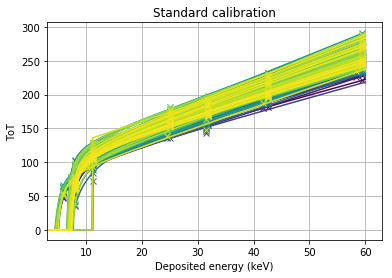

In [79]:
xFit = np.linspace(0, 60, 1000)
x_plot_std, y_plot_std = [], []
popt = (1., 1., 1., 1.)
for i in range(256):
    if i % 16 in [0, 1, 14, 15]:
        continue
    color = getColor('viridis', 256, i - 1)
    x, y = d[i]['mu'], d[i]['ToTmu']
    plt.plot(x, y, marker='x', ls='', color=color)
    try:
        popt, pcov = scipy.optimize.curve_fit(energyToToTSimple, x, y, maxfev=10000)
    except:
        pass
    
    x_plot_std += list(xFit)
    y_plot_std += list(energyToToTSimple(xFit, *popt))
    
    plt.plot(xFit, energyToToTSimple(xFit, *popt), color=color)
plt.xlabel('Deposited energy (keV)')
plt.ylabel('ToT')
plt.title('Standard calibration')
plt.grid()
plt.xlim(left=3)
plt.savefig(PLOT_DIR + 'standard_calib.png', dpi=300)

[ 54.64850378  70.869319    96.07446163 145.25230924 154.9405008
 193.16373155 245.27325031] [ 5.40908586  3.81445973  3.50888437  5.8410347  10.18893786  8.65084335
 11.44585296]


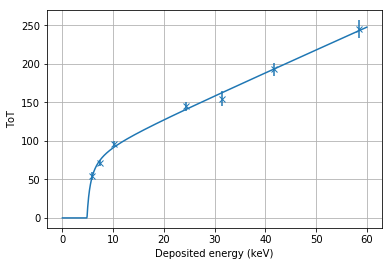

In [110]:
ToT_list = []
energy = sorted(d[2]['mu'])
x_plot_data, y_plot_data = [], []
for pixel in range(256):
    if pixel % 16 in [0, 1, 14, 15]:
        continue
        
    en_sort = np.argsort(d[pixel]['mu'])
    ToT = np.asarray( d[pixel]['ToTmu'] )[en_sort]
    
    ToT_filt = []
    for idx, en in enumerate( energy ):
        if en in d[pixel]['mu']:
            ToT_filt.append( ToT[idx] )
        else:
            ToT_filt.append( np.nan )
    ToT_list.append( ToT_filt )
    
    x_plot_data += list(d[pixel]['mu'])
    y_plot_data += list(d[pixel]['ToTmu'])
    
ToT_mean = np.nanmedian(ToT_list, axis=0)
ToT_sigma = np.nanstd(ToT_list, axis=0)

print ToT_mean, ToT_sigma

# plt.hist2d(x_plot_data, y_plot_data, bins=300)
plt.errorbar(energy, ToT_mean, yerr=ToT_sigma, marker='x', ls='')
popt, pcov = scipy.optimize.curve_fit(energyToToTSimple, energy, ToT_mean)
xFit = np.linspace(0, 60, 1000)
plt.plot(xFit, energyToToTSimple(xFit, *popt), color='C0')

plt.xlabel('Deposited energy (keV)')
plt.ylabel('ToT')
plt.grid()
plt.savefig(PLOT_DIR + 'deviation_all.png', dpi=300)

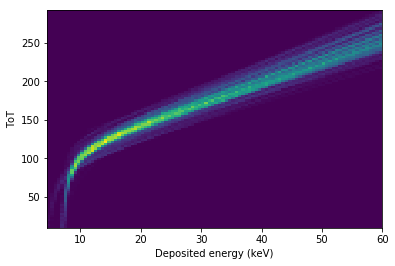

In [88]:
x_plot_std = np.asarray(x_plot_std)
y_plot_std = np.asarray(y_plot_std)
_ = plt.hist2d(x_plot_std[np.logical_and(y_plot_std > 10, x_plot_std < 60)], y_plot_std[np.logical_and(y_plot_std > 10, x_plot_std < 60)], bins=100)
plt.xlabel('Deposited energy (keV)')
plt.ylabel('ToT')
plt.savefig(PLOT_DIR + 'standard_dist.png', dpi=300)

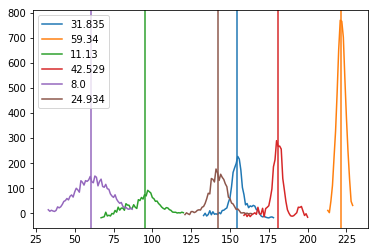

In [8]:
idx = 5
for i in range(len(d[idx]['x'])):
    plt.plot(d[idx]['x'][i], d[idx]['y'][i], label=d[idx]['mu'][i], color='C%d' % i)
    plt.axvline(x=d[idx]['ToTmu'][i], color='C%d' % i)
plt.legend()

0 1 2

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in divide
  """
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()


 3 4 5 6 failed
7 8 9 10 Pixel 10: Fit failed
failed
11 12 13 14 15 Pixel 15: Fit failed
16 17 18 19 20 21 22 23 24 Pixel 24: Fit failed
25 failed
26 27 28 Pixel 28: Fit failed
29 30 31 Pixel 31: Fit failed
failed
32 33 Pixel 33: Fit failed
34 Pixel 34: Fit failed
35 36 37 38 Pixel 38: Fit failed
39 40 Pixel 40: Fit failed
41 Pixel 41: Fit failed
42 43 44 Pixel 44: Fit failed
failed
45 46 47 48 49 50 51 52 53 54 55 56 57 Pixel 57: Fit failed
58 Pixel 58: Fit failed
59 failed
60 Pixel 60: Fit failed
61 Pixel 61: Fit failed
62 63 64 Pixel 64: Fit failed
65 66 Pixel 66: Fit failed
67 68 69 70 71 Pixel 71: Fit failed
72 73 74 Pixel 74: Fit failed
failed
75 76 77 78 79 80 81 82 83 84 Pixel 84: Fit failed
85 Pixel 85: Fit failed
86 87 88 89 90 91 Pixel 91: Fit failed
92 Pixel 92: Fit failed
93 94 95 96 97 98 99 100 101 102 103 104 105 106 Pixel 106: Fit failed
107 108 109 110 111 Pixel 111: Fit failed
112 113 114 115 116 117 118 119 Pixel 119: Fit failed
120 121 122 123 124 failed
125 126 12

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.


 170 171 Pixel 171: Fit failed
172 173 174 175 176 177 178 179 180 181 182 183 Pixel 183: Fit failed
184 185 186 187 188 189 190 191 192 193 194 failed
195 196 197 Pixel 197: Fit failed
198 199 200 201 202 203 204 failed
205 206 207 208 209 210 211 Pixel 211: Fit failed
212 213 214 Pixel 214: Fit failed
215 216 217 218 219 Pixel 219: Fit failed
220 Pixel 220: Fit failed
221 222 223 224 225 226 failed
227 Pixel 227: Fit failed
228 229 230 231 Pixel 231: Fit failed
232 Pixel 232: Fit failed
233 234 Pixel 234: Fit failed
235 236 Pixel 236: Fit failed
237 238 239 240 241 242 Pixel 242: Fit failed
243 244 245 246 247 248 Pixel 248: Fit failed
249 250 251 Pixel 251: Fit failed
failed
252 253 254 255

Text(0.5,1,'Test pulse calibration')

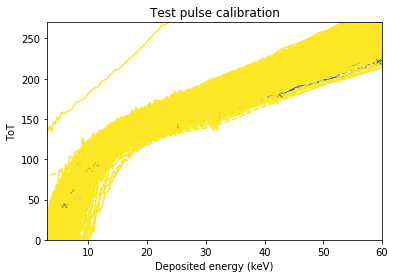

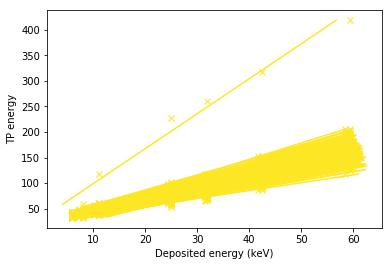

In [86]:
Y_MIN = -10 # 10
CORRECTION = True

# Plot
fig, ax = plt.subplots() # figsize=(10, 5))
fig_tp, ax_tp = plt.subplots() # figsize=(10, 5))

x_plot, y_plot = [], []
var_names = ['a1', 'b1', 'c1', 't1', 'a2', 'b2', 'c2', 't2']
poptSuperDict = {var: [] for var in var_names}
TPtoEnergyParams = {}

for pixel in range(256): # range(0, 1):
    print pixel, 
    volt, ToT, ToTErr = np.asarray(data[pixel // 16]['volt']), np.asarray(data[pixel // 16]['ToT']), np.asarray(data[pixel // 16]['ToTErr'])
    energy = 510-np.asarray(volt)
    
    ToT = ToT[energy > 20]
    energy = energy[energy > 20]

    # Data
    ToTmu, mu = np.asarray(d[pixel + 1]['ToTmu']), np.asarray(d[pixel + 1]['mu'])
    ToTmuErr = np.asarray(d[pixel + 1]['ToTmuErr'])
    sort = np.argsort(mu)
    ToTmu, mu, ToTmuErr = ToTmu[sort], mu[sort], ToTmuErr
    
    # Test pulse measurements
    x, y = energy, np.asarray(ToT).T[pixel % 16]
    
    p0 = (0.5, 25, -40, -12)
    p0_ = (-0.01, -8, 350, 40)
    try:
        popt, pcov = scipy.optimize.curve_fit(energyToToTSimple, x, y, p0=p0)
        popt_, pcov = scipy.optimize.curve_fit(fitFunc2, x[y > Y_MIN], (y - energyToToTSimple(x, *popt))[y > Y_MIN], p0=p0_)
    except:
        # for v, var in enumerate(var_names):
        #    poptSuperDict[var].append( np.mean(poptSuperDict[var]) )
        popt, popt_ = p0, p0_

    try:
        poptSuper, pcovSuper = scipy.optimize.curve_fit(superFit, x[y > Y_MIN], y[y > Y_MIN], p0=np.hstack((popt, popt_)), maxfev=30000)
    except:
        print 'Pixel %d: Fit failed' % pixel
        poptSuper = np.hstack((popt, popt_))

    # Get intersection of ToTmu and test pulse function
    intrscts = []
    for idx in range(len(ToTmu)):
        x0 = ToTtoEnergySimple(ToTmu[idx], *popt)
        intrsct = scipy.optimize.fsolve(lambda t: superFit(t, *poptSuper) - ToTmu[idx], x0=x0)[0]
        intrscts.append( intrsct )
    intrscts = np.asarray(intrscts)
    
    # Fit TP to energy conversion
    try:
        p, pc = scipy.optimize.curve_fit(linear, intrscts, mu)
    except:
        TPtoEnergyParams[pixel] = (1, 0)
        continue
        
    TPtoEnergyParams[pixel] = p
    color = getColor('viridis', 16, pixel)
    ax.errorbar(mu, ToTmu, yerr=ToTmuErr, marker='x', ls='', color=color)
    
    ax_tp.plot(mu, intrscts, marker='x', ls='', color=color)
    ax_tp.plot(linear(intrscts, *p), intrscts, color=color)
    ax.grid(), ax_tp.grid()
    
    # Convert TP x-axis
    m, t = p
    poptSuper = np.asarray(poptSuper) * np.asarray([1./m, m, 1, m, 1./m, m, m, m]) + np.asarray([0, t, 0, 0, 0, t, 0, 0])
    xFit = np.linspace(min(linear(energy, *p)), max(linear(energy, *p)), 1000)
    if not CORRECTION:
        ax.plot(xFit, superFit(xFit, *poptSuper), color=color, ls='--')
    ax.plot(linear(energy, *p), np.asarray(ToT).T[pixel % 16], color=color)
    # ax[0].plot(linear(energy, *p), superFit(energy, *poptSuper), color='C%d' % (pixel % 10), ls='--')
    
    # Apply correction to
    if CORRECTION:
        x, y = linear(energy, *p), np.asarray(ToT).T[pixel % 16]
        x = np.asarray(list(x) + list(mu))
        y = np.asarray(list(y) + list(ToTmu))
        sigma = np.asarray(np.full(len(x), 10), dtype=float)
        sigma[-len(mu):] = 1
        try:
            poptSuper, pcov = scipy.optimize.curve_fit(superFit, x, y, p0=poptSuper, sigma=sigma, maxfev=30000)
        except:
            print 'failed'
            pass
        ax.plot(xFit, superFit(xFit, *poptSuper), color=color, ls='--')
    
    for v, var in enumerate(var_names):
        poptSuperDict[var].append( poptSuper[v] )
    
    # Axis labels
    ax_tp.set_xlabel('Deposited energy (keV)')
    ax.set_ylabel('ToT')
    ax.set_xlabel('Deposited energy (keV)')
    ax_tp.set_ylabel('TP energy')
    
    energy = np.linspace(0, 60, 1000)
    x_ = np.asarray( energy )
    y_ = np.asarray(superFit(energy, *poptSuper))
    x_plot += list(x_[y_ < 350])
    y_plot += list(y_[y_ < 350])
    
    '''
    ax[0].plot(energy, np.asarray(ToT).T[pixel % 16], color='C%d' % (pixel % 10))
    ax[0].plot(energy, superFit(energy, *poptSuper), color='C%d' % (pixel % 10), ls='--')
    for i in range(len(ToTmu)):
        ax[0].axhline(y=ToTmu[i])
        ax[0].axvline(x=intrscts[i])
    '''

ax.grid()
ax_tp.grid()
ax.set_xlim(3, 60)
ax.set_ylim(0, 270)
ax.set_title('Test pulse calibration')

# fig.savefig(PLOT_DIR + 'tp_calibration.png', dpi=300)
# fig_tp.savefig(PLOT_DIR + 'deposited_to_tp_energy.png', dpi=300)

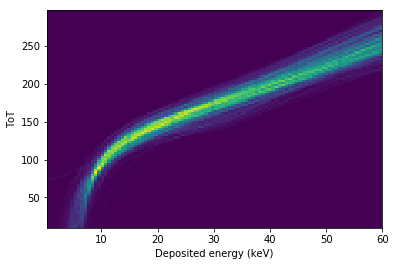

In [89]:
x_plot = np.asarray(x_plot)
y_plot = np.asarray(y_plot)
_ = plt.hist2d(x_plot[np.logical_and(y_plot > 10, x_plot < 60)], y_plot[np.logical_and(y_plot > 10, x_plot < 60)], bins=100)
plt.xlabel('Deposited energy (keV)')
plt.ylabel('ToT')
plt.savefig(PLOT_DIR + 'imp_dist.png', dpi=300)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in divide
  app.launch_new_instance()
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in divide
  app.launch_new_instance()


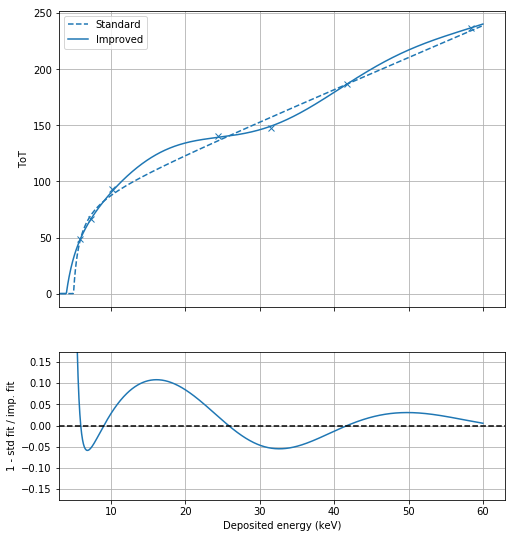

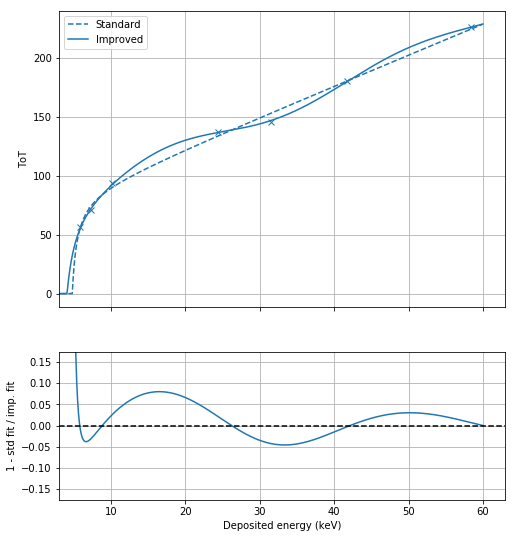

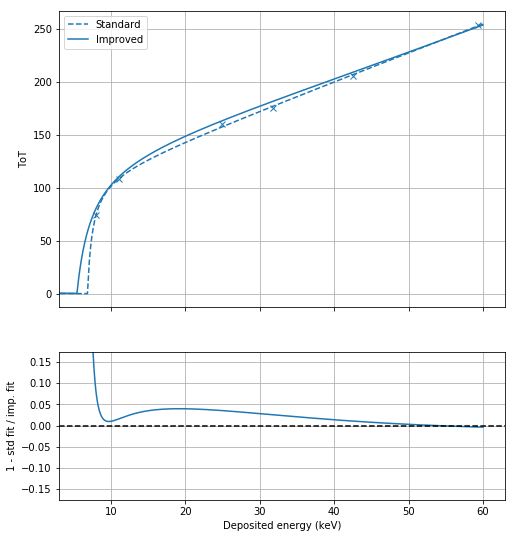

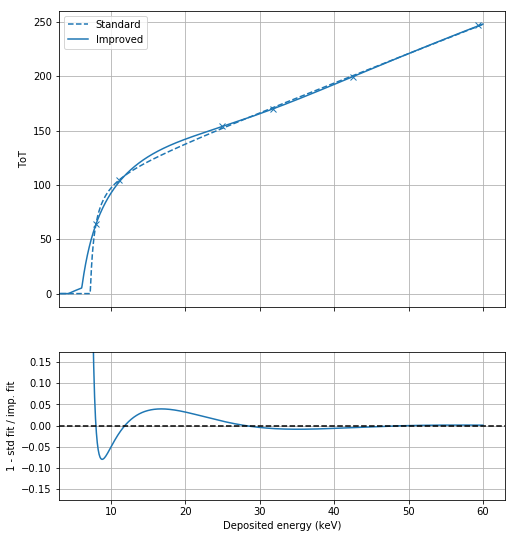

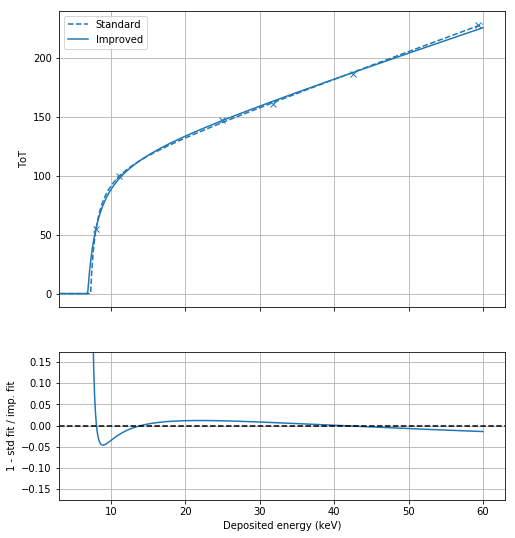

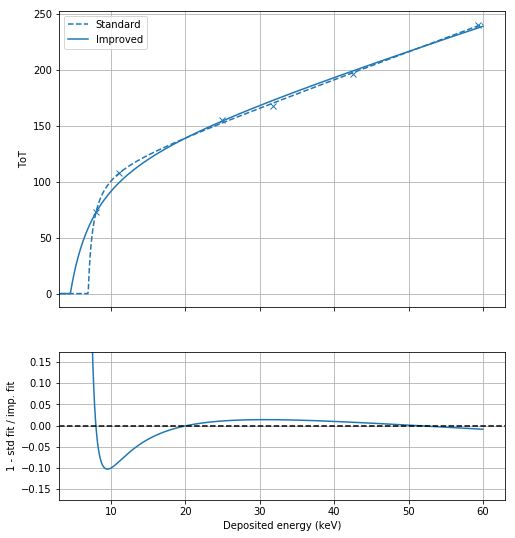

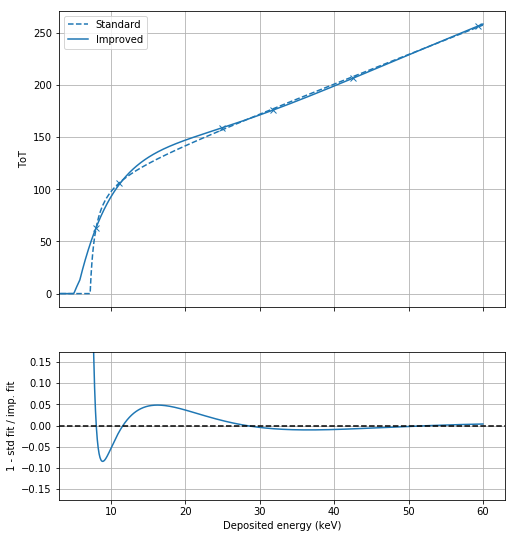

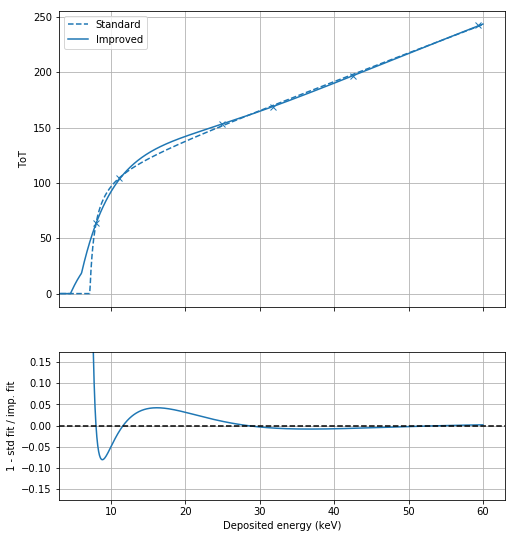

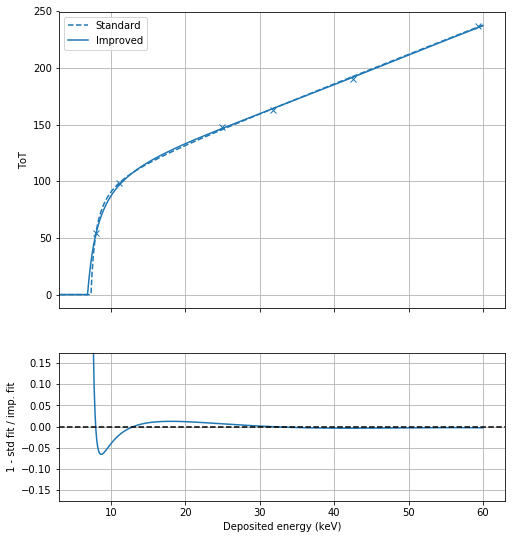

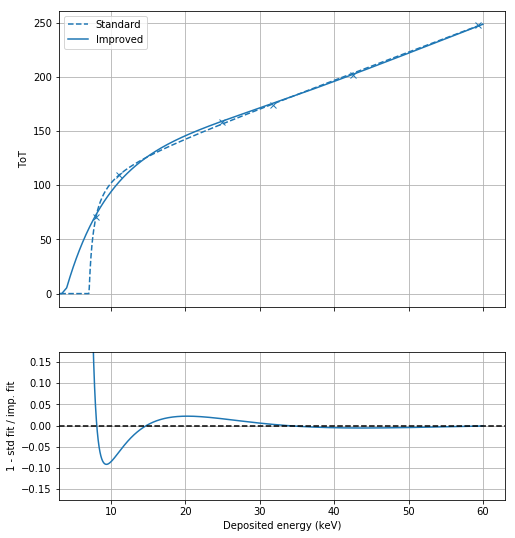

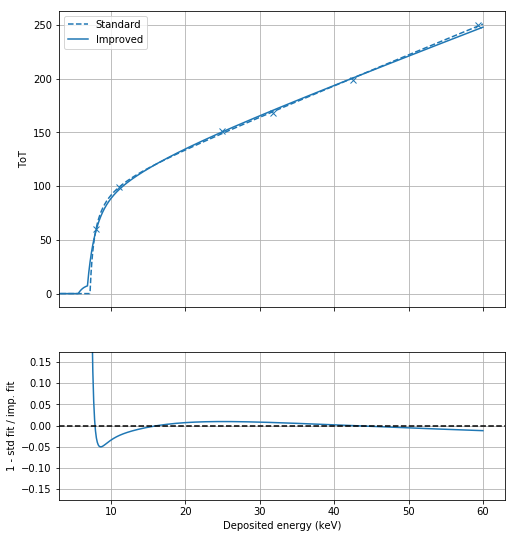

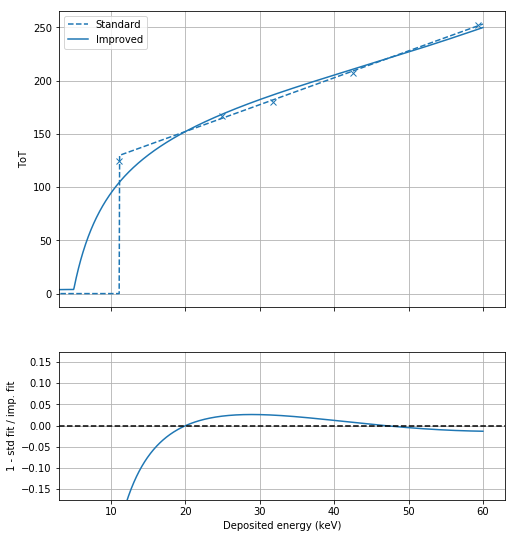

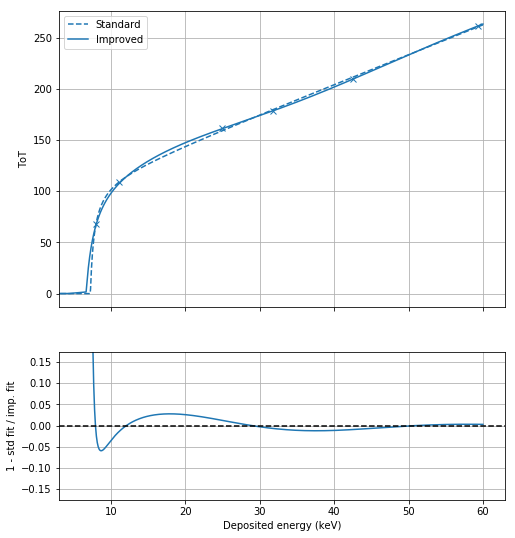

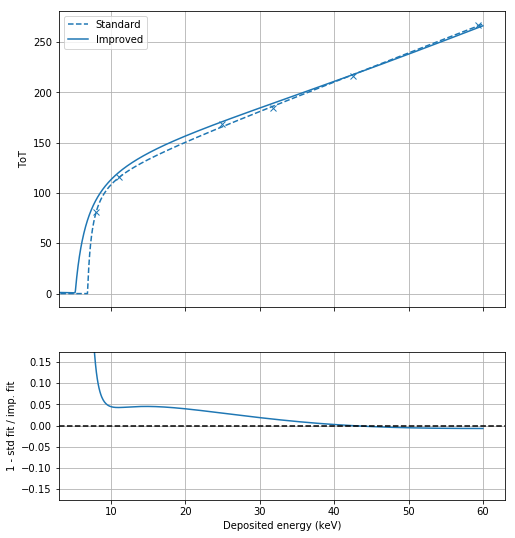

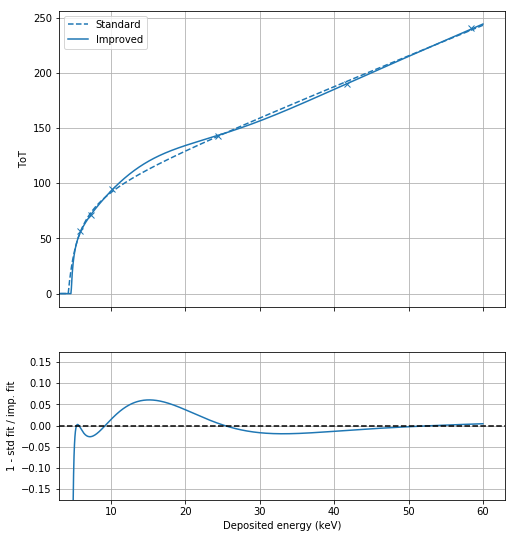

In [29]:
for i in range(17, 32):
    xFit = np.linspace(0, 60, 1000)

    fig, ax = plt.subplots(2, 1, figsize=(8, 9), gridspec_kw={'height_ratios': [2, 1]}, sharex=True)
    color = 'C0' # getColor('viridis', 16, i)
    x, y = d[i]['mu'], d[i]['ToTmu']
    y_err = d[i]['ToTmuErr']
    ax[0].plot(x, y, marker='x', ls='', color=color)
    popt, pcov = scipy.optimize.curve_fit(energyToToTSimple, x, y)

    ax[0].plot(xFit, energyToToTSimple(xFit, *popt), color=color, ls='--', label='Standard')
    poptSuper = [poptSuperDict[var][i-1] for var in var_names]
    ax[0].plot(xFit, superFit(xFit, *poptSuper), color=color, label='Improved')
    ax[0].legend()

    dev = 1 - energyToToTSimple(xFit, *popt) / superFit(xFit, *poptSuper)
    xFit = xFit[dev < 0.5]
    dev = dev[dev < 0.5]
    ax[1].plot(xFit, dev, color='C0')
    ax[1].axhline(y=0, ls='--', color='k')
    ax[1].set_ylim(-0.175, 0.175)
    ax[1].grid()

    ax[1].set_xlabel('Deposited energy (keV)')
    ax[1].set_ylabel('1 - std fit / imp. fit')
    ax[0].set_ylabel('ToT')
    ax[0].grid()

    ax[0].set_xlim(left=3)
    fig.savefig(PLOT_DIR + 'calib_corr/standard_calib_corr_%d.png' % i, dpi=300)

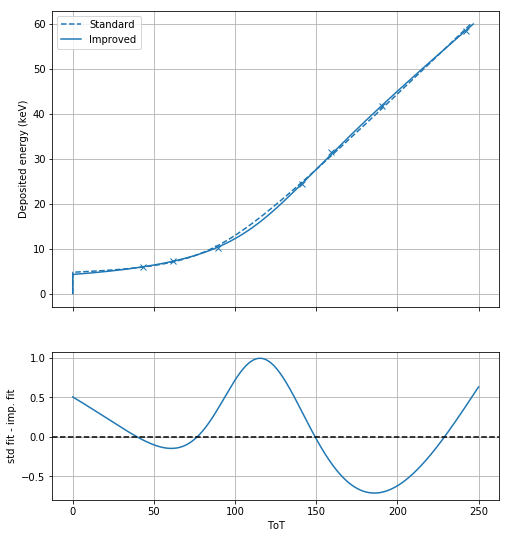

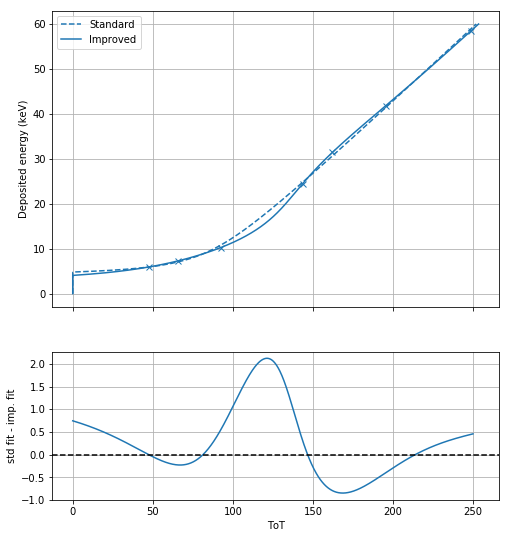

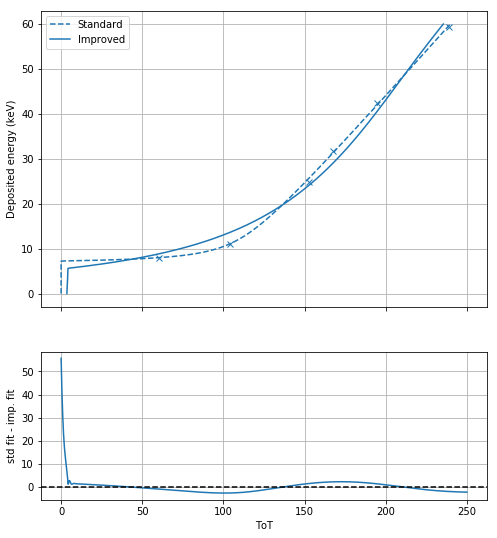

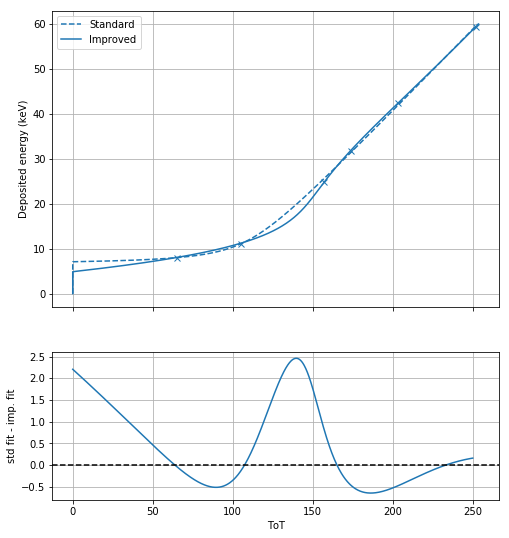

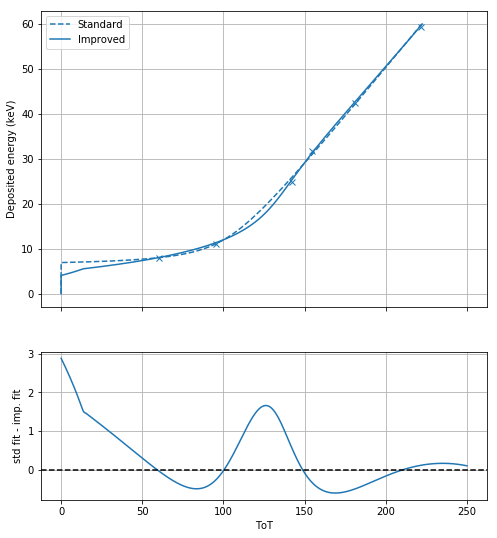

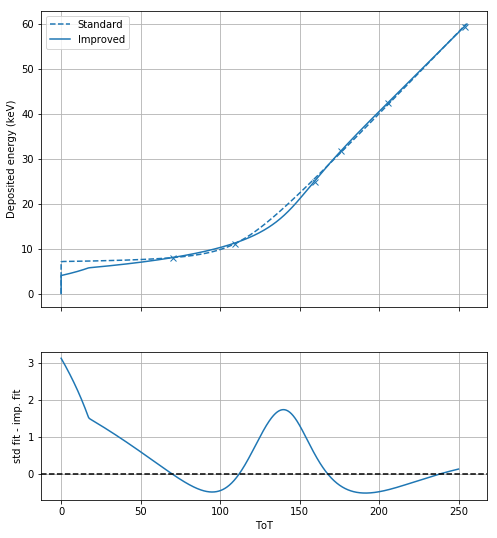

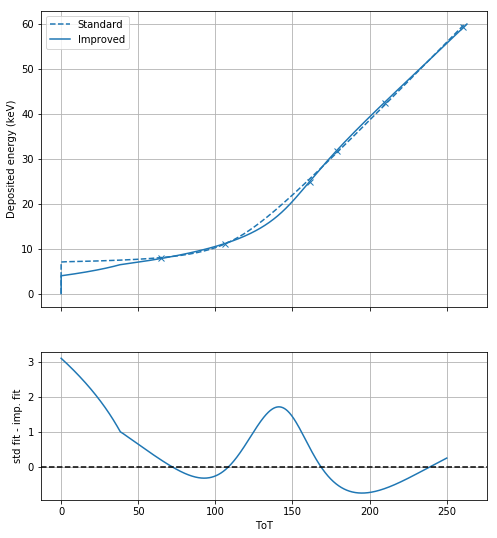

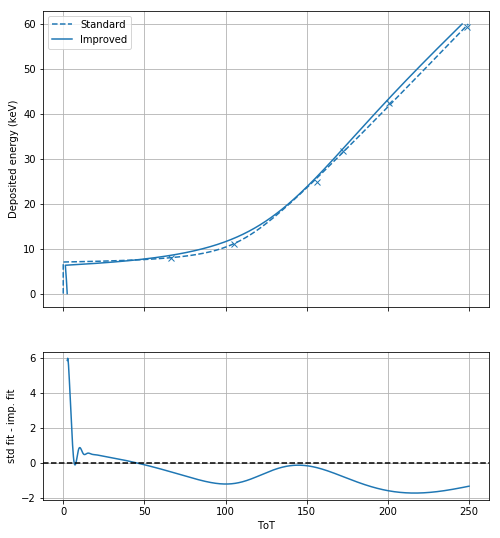

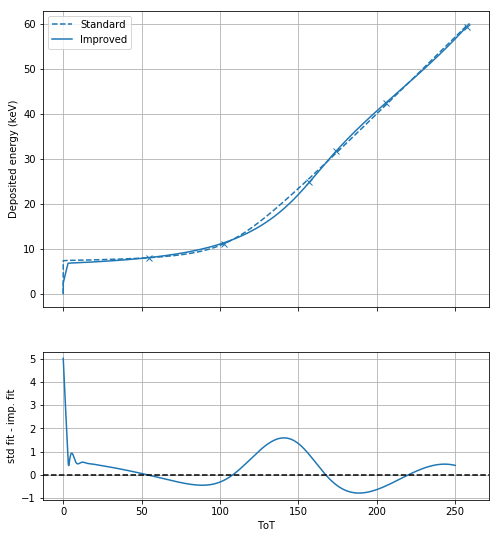

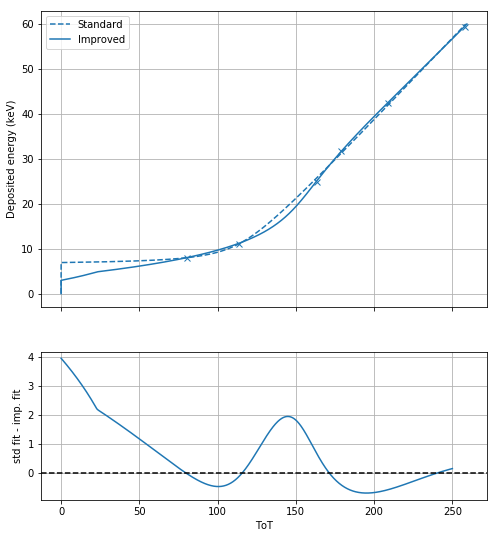

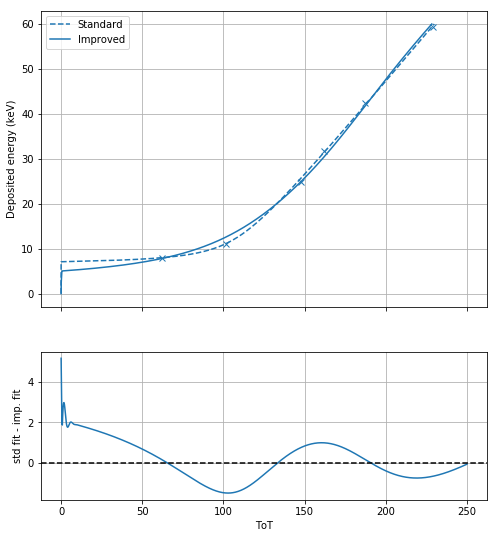

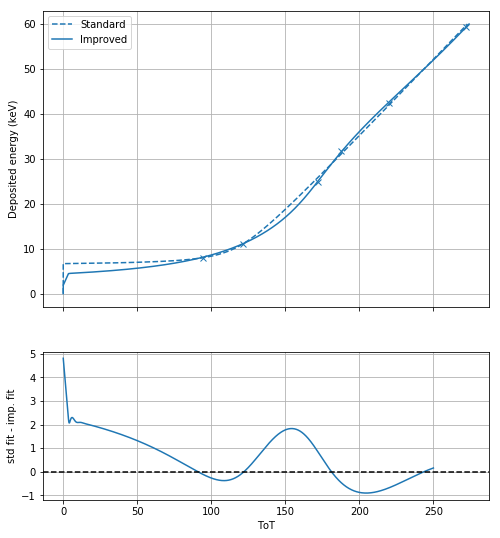

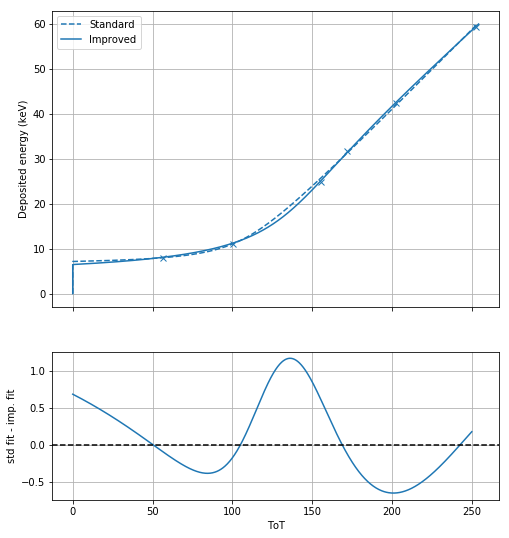

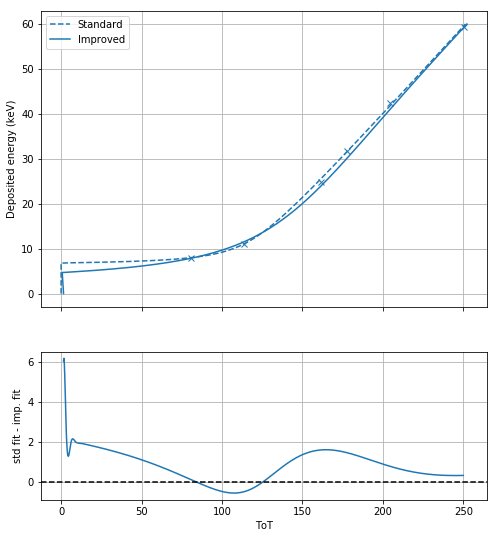

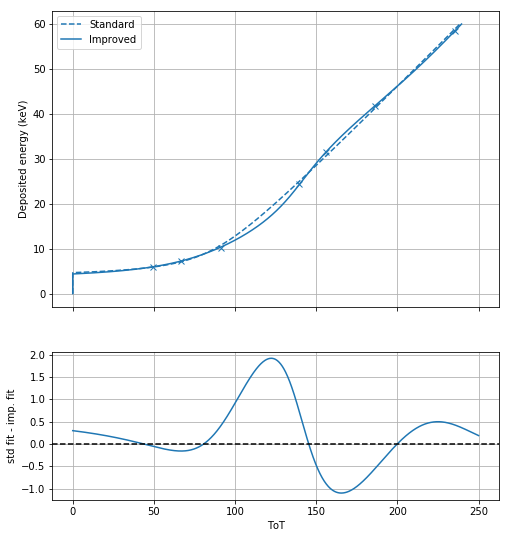

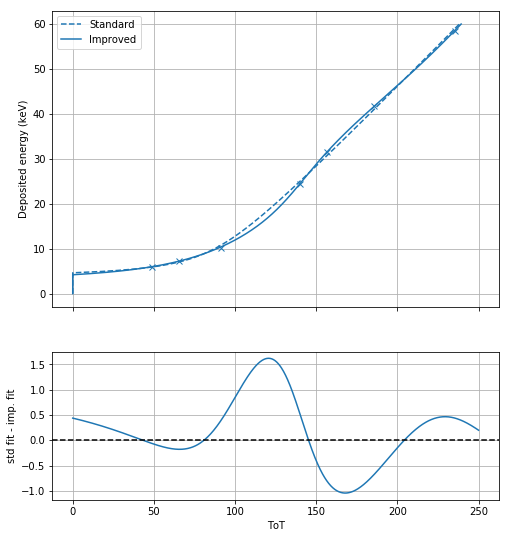

In [15]:
for i in range(1, 17):
    color = 'C0'
    xFit = np.linspace(0, 60, 1000)
    fig, ax = plt.subplots(2, 1, figsize=(8, 9), gridspec_kw={'height_ratios': [2, 1]}, sharex=True)
    x, y = d[i]['mu'], d[i]['ToTmu']
    ax[0].plot(y, x, marker='x', ls='', color=color)
    popt, pcov = scipy.optimize.curve_fit(energyToToTSimple, x, y)

    ax[0].plot(energyToToTSimple(xFit, *popt), xFit, color=color, ls='--', label='Standard')
    poptSuper = [poptSuperDict[var][i-1] for var in var_names]
    ax[0].plot(superFit(xFit, *poptSuper), xFit, color=color, label='Improved')
    ax[0].legend()

    x, y = energyToToTSimple(xFit, *popt), xFit
    ip1 = scipy.interpolate.InterpolatedUnivariateSpline(x[x > 0], y[x > 0])
    x, y = superFit(xFit, *poptSuper), xFit
    ip2 = scipy.interpolate.InterpolatedUnivariateSpline(x[x > 0], y[x > 0])
    x = np.linspace(0, 250, 1000)

    dev = ip1(x) - ip2(x)
    ax[1].plot(x, dev, color='C0')
    ax[1].axhline(y=0, ls='--', color='k')
    #ax[1].set_ylim(-0.175, 0.175)
    ax[1].grid()

    ax[0].grid()
    ax[1].set_xlabel('ToT')
    ax[0].set_ylabel('Deposited energy (keV)')
    ax[1].set_ylabel('std fit - imp. fit')
    fig.savefig(PLOT_DIR + '/en_dev/standard_calib_corr_%d_en_dev.png' % i, dpi=300)

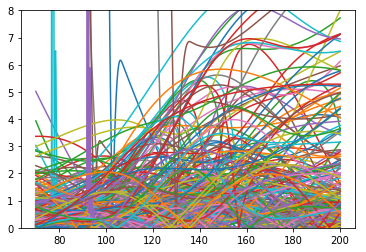

(0, 8)

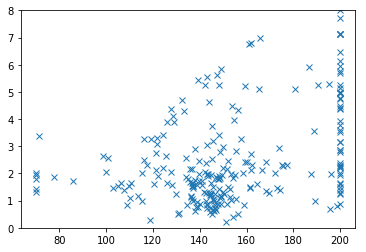

In [24]:
x_dev, y_dev = [], []
for i in range(1, 256):
    xFit = np.linspace(0, 60, 1000)
    x, y = d[i]['mu'], d[i]['ToTmu']
    popt, pcov = scipy.optimize.curve_fit(energyToToTSimple, x, y, maxfev=10000)

    x, y = energyToToTSimple(xFit, *popt), xFit
    ip1 = scipy.interpolate.InterpolatedUnivariateSpline(x[x > 0], y[x > 0])
    poptSuper = [poptSuperDict[var][i-1] for var in var_names]
    x, y = superFit(xFit, *poptSuper), xFit
    ip2 = scipy.interpolate.InterpolatedUnivariateSpline(x[x > 0], y[x > 0])
    x = np.linspace(70, 200, 1000)

    dev = abs(ip1(x) - ip2(x))
    plt.plot(x, dev)
    max_dev_idx = np.argmax(dev)
    x_dev.append(x[max_dev_idx]), y_dev.append(abs(dev)[max_dev_idx])
plt.ylim(0, 8)
plt.show()

plt.plot(x_dev, y_dev, marker='x', ls='')
plt.ylim(0, 8)

In [349]:
hickle.dump(poptSuperDict, '../../dpx_data/detector1ParamsTHL20_super.hck')

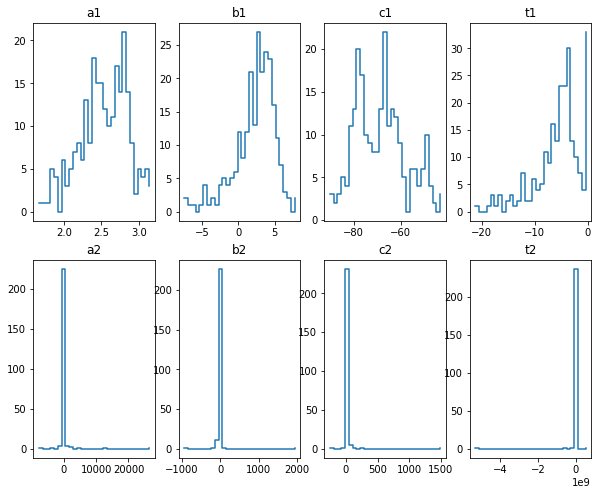

In [338]:
fig, ax = plt.subplots(2, 4, figsize=(10, 8))
ax = np.asarray(ax).flatten()
for idx, var in enumerate(var_names):
    elm = np.asarray(poptSuperDict[var])
    elm = elm[abs(elm - np.mean(elm)) < 3 * np.std(elm)]
    hist, bins = np.histogram(elm, bins=30)
    ax[idx].step(bins[:-1], hist, where='post')
    
    # ax[idx].hist(poptSuperDict[var], bins=30)
    ax[idx].set_title(var)

In [7]:
TP_IKRUM_DIRECTORY = '../../dpx_data/TPtoToT_Dennis1/'
TP_IKRUM_FN = 'TPtoToT_detector%d_Ikrum%d.hck'
IkrumList = [11, 20, 30, 40, 50, 60, 70, 80]

In [8]:
dataDict = {}
for Ikrum in IkrumList:
    data = hickle.load(TP_IKRUM_DIRECTORY + TP_IKRUM_FN % (1, Ikrum))
    x = 510 - np.asarray(data[0]['volt'])
    dataDict[Ikrum] = {}
    for pixel in range(256):
        y = np.asarray(data[pixel // 16]['ToT']).T[pixel % 16]
        # y = y[x > 0]
        # x = x[x > 0]

        dataDict[Ikrum][pixel] = {'x': x, 'y': y}

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in divide
  """


Pixel 12, Ikrum 60: Fit failed


Text(0,0.5,'ToT')

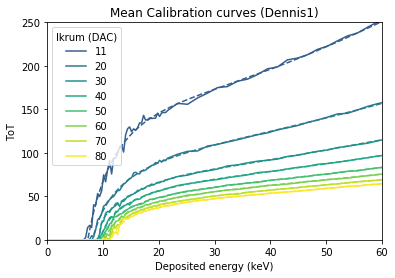

In [20]:
poptSuperIkrumDict = {}

pixel = 12
for Ik_idx, Ikrum in enumerate(IkrumList):
    data = dataDict[Ikrum]
    # Test pulse measurements
    x, y = data[pixel]['x'], data[pixel]['y']
    # x = np.mean([data[pixel]['x'] for pixel in range(256)], axis=0)
    # y = np.mean([data[pixel]['y'] for pixel in range(256)], axis=0)

    p0 = (0.5, 25, -40, -12)
    p0_ = (-0.01, -15, 350, 40)
    try:
        popt, pcov = scipy.optimize.curve_fit(energyToToTSimple, x, y, p0=p0)
        popt_, pcov = scipy.optimize.curve_fit(fitFunc2, x[y > Y_MIN], (y - energyToToTSimple(x, *popt))[y > Y_MIN], p0=p0_)
    except:
        # for v, var in enumerate(var_names):
        #    poptSuperDict[var].append( np.mean(poptSuperDict[var]) )
        popt, popt_ = p0, p0_

    try:
        poptSuper, pcovSuper = scipy.optimize.curve_fit(superFit, x, y, p0=np.hstack((popt, popt_)), maxfev=3000)
    except:
        print 'Pixel %d, Ikrum %d: Fit failed' % (pixel, Ikrum)
        poptSuper = np.hstack((popt, popt_))

    # Rescale
    try:
        m, t = TPtoEnergyParams[pixel]
    except:
        continue
    poptSuper = np.asarray(poptSuper) * np.asarray([1./m, m, 1, m, 1./m, m, m, m]) + np.asarray([0, t, 0, 0, 0, t, 0, 0])

    xFit = np.linspace(min(linear(x, m, t)), max(linear(x, m, t)), 1000)
    color = getColor('viridis', 3 + len(IkrumList), 3 + Ik_idx)
    plt.plot(linear(x, m, t), y, color=color, label=Ikrum)
    plt.plot(xFit, superFit(xFit, *poptSuper), color=color, ls='--')

    poptSuperIkrumDict[Ikrum] = {'popt': poptSuper, 'x': linear(x, m, t), 'y': y}
    
leg = plt.legend(title='Ikrum (DAC)')
plt.xlim(0, 60)
plt.ylim(0, 250)
plt.title('Mean Calibration curves (Dennis1)')
plt.xlabel('Deposited energy (keV)')
plt.ylabel('ToT')

In [21]:
hickle.dump(poptSuperIkrumDict, '../../dpx_data/TPtoToT_Dennis1/detector1ParamsTHL20_super_Ikrum.hck')